<a href="https://colab.research.google.com/github/Dkepffl/2022-2-ESAA/blob/main/Assignment/Assignment220926_ensemble_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **캐글 실습 필사 : Titanic Top 4% with ensemble modeling**
___
출처 : https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1. Introduction**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter # list 원소들의 개수를 알고 싶을 때 사용한다.

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

### **2. Load and check data**

#### | **2.1 load data**
___
- 학습 데이터셋과 테스트 데이터셋을 로드하고, 테스트셋의 `PassengerId` 컬럼을 추출하여 따로 저장한다.

In [3]:
# Load data

train = pd.read_csv("/content/drive/MyDrive/2022-2 ESAA/Data/titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/2022-2 ESAA/Data/titanic/test.csv")
IDtest = test["PassengerId"]

#### | **2.2 Outlier detection**
___
- Outlier들은 모델의 예측 성능에, 특히 회귀에서, 큰 영향을 줄 수 있기 때문에, 알맞게 처리해주어야 한다.
- 아래의 `detect_outliers` 함수는 Tukey method에 따라 주어진 데이터셋의 지정된 피처에서 n개 이상의 outlier를 찾아내 그 인덱스를 리스트로 반환하는 함수이다.
- 이 함수를 이용하여, `Age`,`SibSp`,`Parch`, `Fare` 컬럼들에서 2개 이상의 이상치를 가지고 있는 행의 인덱스를 확인해보았다.

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    outlier_indices = []
    
    # 각 컬럼별로 반복
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # 이상치에 해당하는 값의 인덱스 구하기
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # 위에서 얻은 인덱스를 리스트에 추가
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices) # outlier의 개수 반환        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n ) # 2개 이상의 이상치를 가지고 있는 관측치(행) 반환
    
    return multiple_outliers   

In [5]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [6]:
len(Outliers_to_drop)

10

- Numerical Variable을 가진 Column들 중 Outlier를 2개 이상 가진 행을 10개 찾아내었다.
- 아래 코드를 보면,
  - 승객 28, 89, 342은 `Fare` 컬럼에서 매우 큰 값을 가지고 있다.
  - 다른 7명은 `SibSP` 컬럼에서 매우 큰 값을 가지고 있다.

In [7]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 발견한 10개의 이상치들을 제거해주었다.

In [8]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

#### | **2.3 joining train and test set**
___
- Feature Engineering을 할 때, train과 test 데이터셋이 같은 개수의 피처를 가지도록 하기 위해 두 데이터셋을 합쳤다.

In [9]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

#### | **2.4 check for null and missing value**
___
- 이제 Missing value들을 처리해보자.
- 아래와 같이 값이 없거나 `NaNs` 값을 가진 값들을 `NaN`으로 채워주었다.
- 그리고 각 컬럼별로 NaN 값의 개수를 확인해보았다.

In [10]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan) 

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- `Age`와 `Cabin`은 상당수의 결측치를 가지고 있다.
- train 데이터셋만 살펴보면, 위에서 확인한 타겟값 `Survied` 컬럼에 있는 418개의 결측치는 test 데이터셋에 있는 값에 해당하기 때문에 따로 처리하지 않아도 된다.

In [11]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [14]:
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### **3. Feature analysis**

#### | **3.1 Numerical values**
___
- Numerical variable과 타겟값인 `Survived` 컬럼 사이의 상관 행렬을 그려보았다.
- seaborn의 `heatmap()`을 이용하였다.

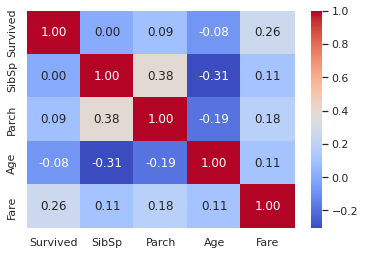

In [15]:
# Correlation matrix between numerical values(SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

- `Fare` 피처만 타겟값과 상당한 상관 관계를 가지고 있는 것처럼 보인다.
- 그렇다고 해서 다른 피처들이 쓸모없는 것은 아니다.
- 이 피처들의 하위 집단들이 타겞값과 상관 관계를 가지고 있을지도 모른다.
- 이를 알아보기 위해, 조금 더 자세하게 피처들을 살펴보도록 하자.

##### **SibSP**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


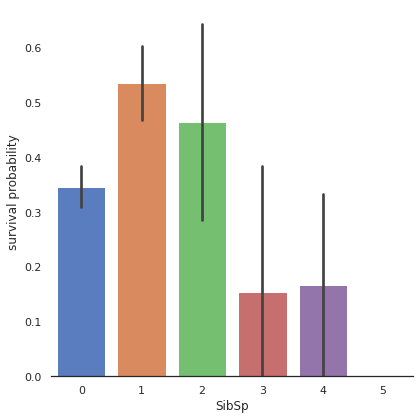

In [16]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 형제를 많이 가지고 있는 승객들의 생존 확률이 낮은 것처럼 보인다.
- 외동이거나 형제를 한두 명 가지고 있는 승객이 더 많이 살아남았다.
- Feature Engineering 파트에서 이 결과를 이용하여, 새로운 피처를 만들어볼 예정이다.

##### **Parch**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


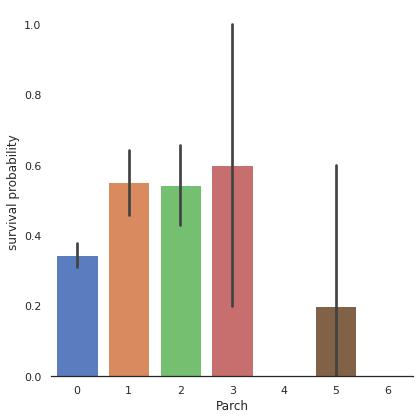

In [17]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 가족 수가 적을수록, 살아남을 확률이 높은 것처럼 보인다.
- `Parch`컬럼 값이 3인 값들에 중요한 표준편차가 있다.

##### **Age**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


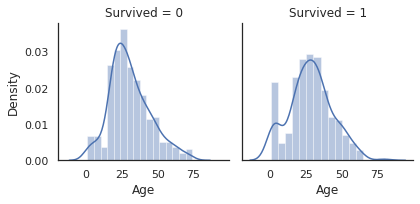

In [18]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

- `Age` 컬럼값의 분포는 정규분포처럼 보인다.
- 생존자와 사망자의 `Age` 컬럼의 분포가 같지 않다.
- 60~80세 사이의 승객의 생존 확률이 낮은 것 같다.
- 매우 어린 승객들일수록 더 많이 살아남은 것 같다.

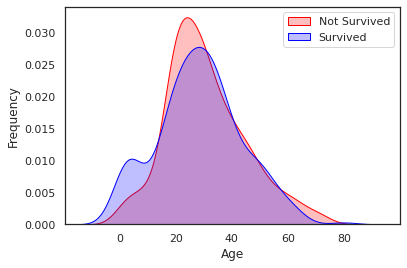

In [19]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

- 두 분포를 함께 보았을 때, 아주 어린 승객들일 때 급격하게 생존자가 많아진 것을 확인할 수 있다.

##### **Fare**

In [20]:
dataset["Fare"].isnull().sum()

1

In [21]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

- `Fare` 컬럼은 결측치를 하나만 가지고 있기 때문에, 예측에 큰 영향을 주지 않아 중간값으로 결측치를 대체해주었다.
- 이제 `Fare` 컬럼의 분포를 살펴보자.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


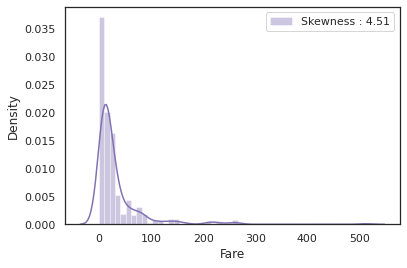

In [22]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- `Fare` 컬럼은 왜도가 매우 크다.
- 이는 매우 높은 값들에 가중치가 부여되어 모델의 예측 성능이 떨어질 수 있기 때문에, Scaling을 해주어야 한다.
- 로그 변환을 이용하여, 스케일링을 해주고 다시 분포를 살펴보았다.

In [23]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


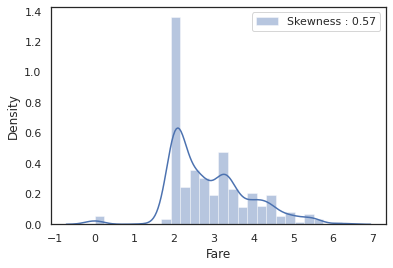

In [24]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 이전보다 왜도가 감소한 것을 확인할 수 있다.

#### | **3.2 Categorical values**
___

##### **Sex**

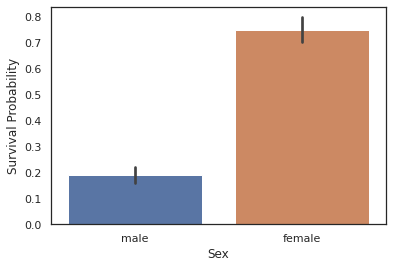

In [25]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [26]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성이 여성보다 적은 생존 확률을 가지고 있다.
- 따라서 `Sex` 컬럼은 생존자 예측에 중요한 예측을 할 것으로 보인다.

##### **Pclass**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


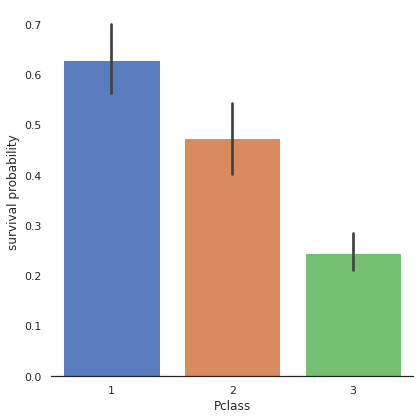

In [27]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 성별에 따른 `PClass` 컬럼 값의 분포도 확인해보았다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


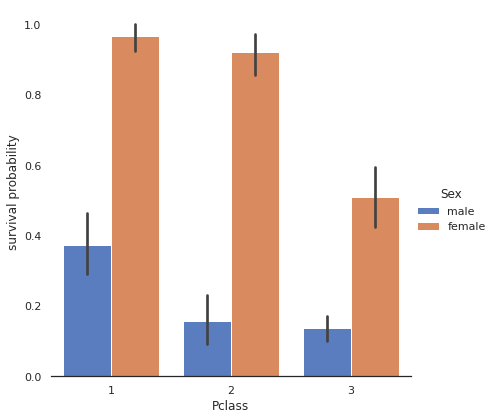

In [28]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 두 성별 모두 1등급 승객들이 2등급이나 3등급 승객들보다 생존확률이 높은 것으로 보인다.

##### **Embarked**

In [29]:
dataset["Embarked"].isnull().sum()

2

In [30]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

- `Fare` 컬럼처럼 `Embarked` 컬럼 역시 결측치의 개수가 적기 때문에, 예측에 큰 영향을 주지 않아 최빈값(`'S'`)으로 결측치를 대체해주었다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


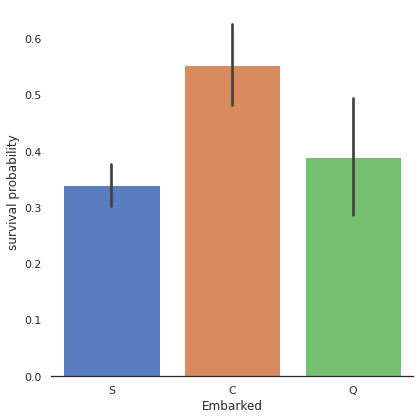

In [31]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- Cherbourg(C)에서 출발한 승객의 생존 확률이 높아 보인다.
- 이는 1등급 승객 중 Cherbourg에서 출발한 승객이 다른 두 출발지보다 많아, 그런 것은 아닐지 확인해보았다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


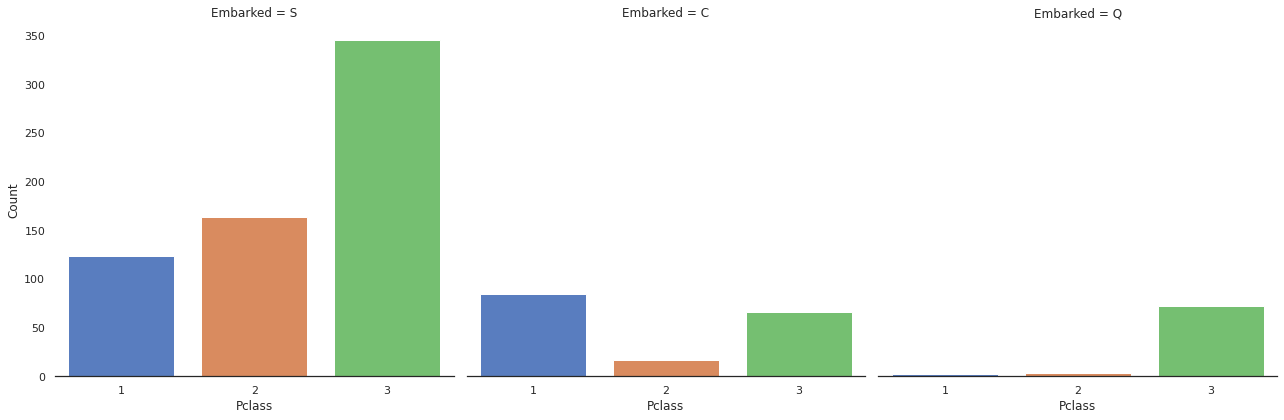

In [32]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

- 그 결과, Southampton과 Queenstown에서 출발한 승객들은 3등급 승객이 가장 큰 비중을 차지하였고, Cherbourg에서 출발한 승객은 1등급 승객이 가장 큰 비율을 차지한다는 것을 확인하였다.

### **4. Filling missing Values**

#### | **4.1 Age**
___
- `Age` 컬럼은 전체 데이터셋에서 256개의 missing value를 가지고 있다.
- 예측에 영향을 줄 수 있는 컬럼이기 때문에, `Age` 피처를 제거하지 않고, Imputation을 이용하여 결측치를 대체할 예정이다.
- 이를 위해, `Age`와 상관 관계가 큰 `Sex`, `Parch`, `Pclass`, `SibSP` 컬럼을 살펴보았다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


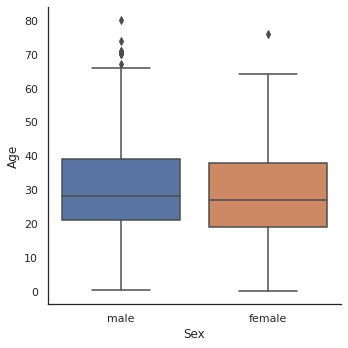

In [33]:
# Explore Age vs Sex
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")

- `Age` 컬럼 분포는 두 성별 하위 집단에서 비슷한 양사을 보이고 있다.
- 따라서 `Sex` 컬럼은 `Age`를 예측하기 위한 정보를 갖고 있는 컬럼이 아니다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


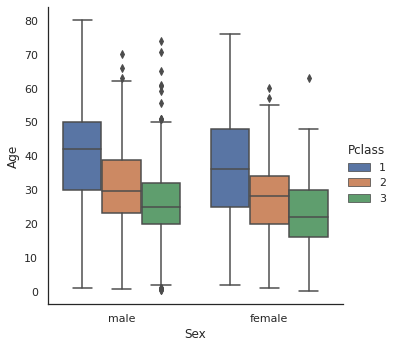

In [34]:
# Explore Age vs Parch
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")

- 반면 1등급 승객은 2등급 승객이나 3등급 승객보다 나이대가 높다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


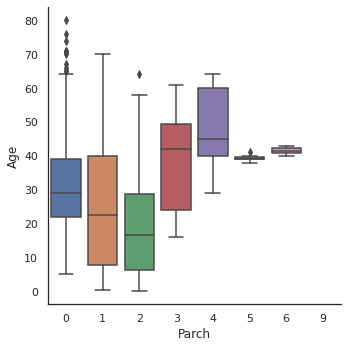

In [35]:
# Explore Age vs Pclass
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")

- 또한 부모님이나 자식 수가 많을 수로 연령대가 높았다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


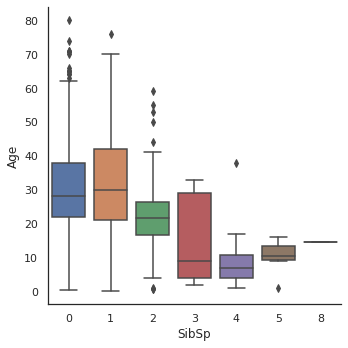

In [36]:
# Explore Age vs SibSP
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

- 형제/자매 수가 많을수록 연령대가 낮았다.
- 이번에는 `Sex` 컬럼의 값을 male은 0, female은 1로 바꾼 후, `Sex`, `Parch`, `Pclass`, `SibSP`와의 상관 행렬을 그려보았다.

In [37]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

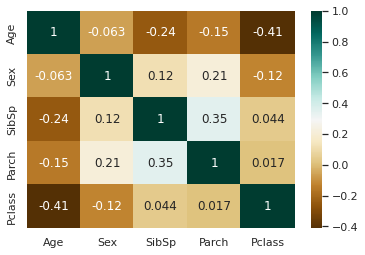

In [38]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

- 상관 행렬을 보면, `Age` 컬럼은 `Sex` 컬럼과 상관 관계가 거의 없으며, `Pclass`, `Parch` 그리고 `SibSp` 컬럼과는 음의 상관 관계를 가지고 있다.
- 따라서 `Pclass`, `Parch`, `SibSp` 컬럼을 이용하여, `Age` 컬럼의 결측값을 대체할 예정이다.
  + 세 개의 컬럼에서 비슷한 값을 가진 관측치들의 `Age` 중앙값으로 결측치를 대체한다.

In [ ]:
# Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


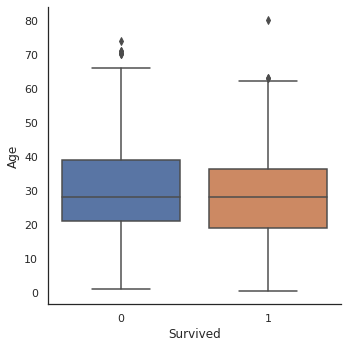

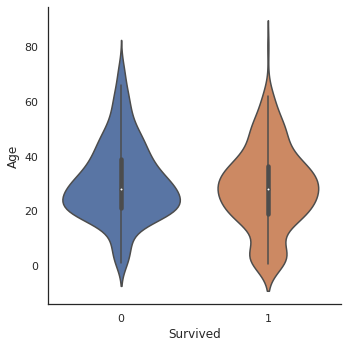

In [40]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

### **5. Feature engineering**

#### | **5.1 Name/Title**
___
- `Name` 피처는 승객들의 이름에 대한 정보를 가지고 있다.
- 대피할 때 특정한 직함(title)을 가진 일부 승객이 먼저 대피했을 수 있으므로, 이 피처를 모델에 추가하는 것이 좋을 것 같다.

In [41]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [42]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

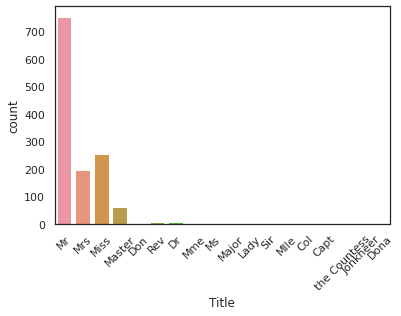

In [43]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) # X축 레이블 설정

- 데이터셋은 17개의 title이 있다. 대부분의 title이 소수이기 때문에, 이들을 묶어 크게 4개의 범주를 만든다.

In [44]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare') # 소수의 title
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3}) # 라벨 인코딩
dataset["Title"] = dataset["Title"].astype(int) # 정수형 변환

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


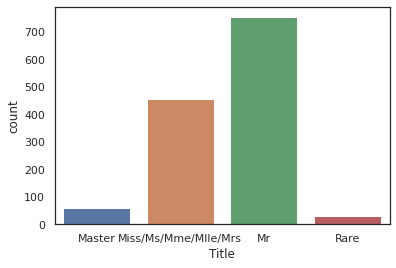

In [45]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


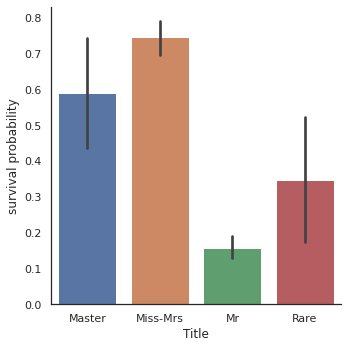

In [46]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [47]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

#### | **5.2 Family Size**
___
- 대가족은 그들의 형제자매나 부모님을 챙겨야 하기 때문에, 대피가 조금 더 어려울 것 같다.
- 그래서 `SibSp` 컬럼과 `Parch` 컬럼 값의 합에 1을 더하여(자기 자신), 가족 수를 의미하는 `Fize` 컬럼을 생성하기로 했다.

In [48]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


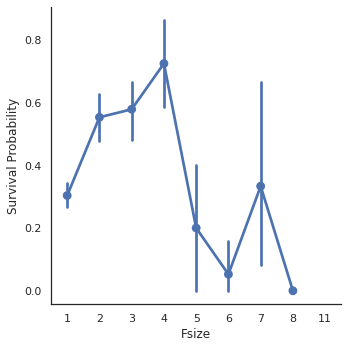

In [49]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

- 가족 수가 많을수록 생존 확률이 낮은 것처럼 보인다.
- 또한 가족 수에 대한 4가지 범주형 변수를 만들었다.

In [50]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


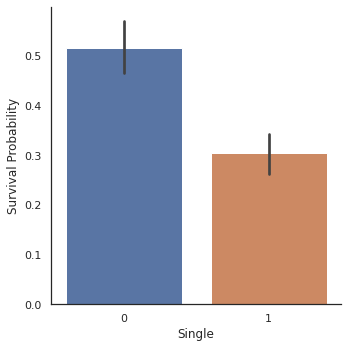

In [52]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


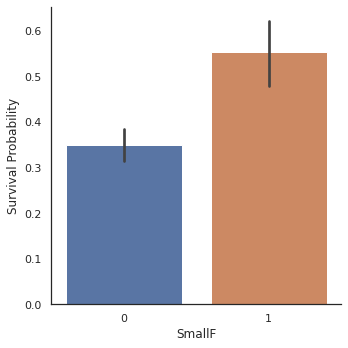

In [53]:
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


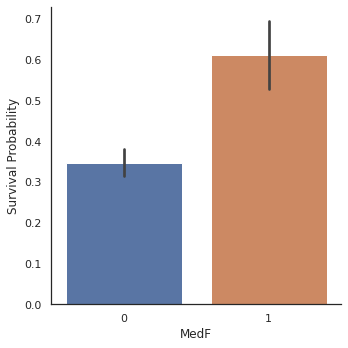

In [54]:
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


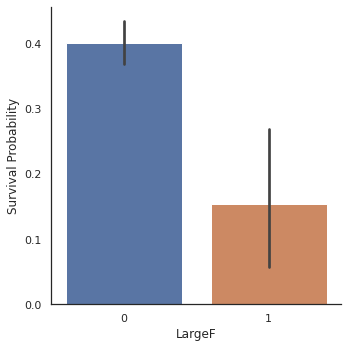

In [55]:
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

- 위 그래프를 통해, 가족 수가 Small 혹은 Medium인 승객들의 생존 확률이 더 높은 것을 확인하였다.
- `Title` 컬럼과 `Embarked` 컬럼의 더미 변수들을 만들어 숫자값으로 바꿔 주었다.

In [56]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [57]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


#### | **5.3 Cabin**
___

In [58]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [59]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [60]:
dataset["Cabin"].isnull().sum()

1007

- `Cabin` 컬럼은 1299개의 값 중 1007개의 결측값을 갖고 있다.
- `Cabin` 컬럼값이 없는 값들은 선실을 예약하지 않은 승객들이라고 가정하였다.

In [61]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [62]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

- `Cabin` 컬럼값의 첫 글자는 Desk를 의미한다.
- 이 글자를 별도의 컬럼에 저장하였다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


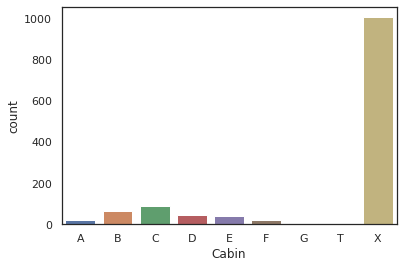

In [63]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


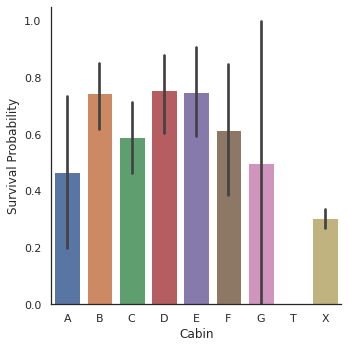

In [64]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

- 선실을 가지고 있는 승객들이 적어, desk의 종류가 생존 확률에 어떤 영향을 미쳤는지 알기 어렵다.
- 다만, 선실이 있는 승객들의 생존 확률이 더 높아 보인다.

In [65]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [66]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


#### | **5.4 Ticket**
___

In [67]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [68]:
# Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [69]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

- `Ticket` 컬럼의 값을 접두사 부분으로 바꿔주었다.

In [70]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [71]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [72]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


### **6. Modeling**
- 모델링을 하기 전, 합쳤던 train과 test 데이터셋을 다시 분할해주었다.
- 또한 train 데이터셋을 피처 데이터셋과 타겟값으로 나누었다.

In [73]:
# Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:
# Separate train features and label 

train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### | **6.1 Simple modeling**
___
##### **6.1.1 Cross validate models**
: Stratified KFold 교차 검증을 이용하여, 자주 쓰이는 10개의 분류 모델을 훈련시키고, 정확도를 기준으로 모델의 성능을 평가하였다. 모델 목록은 아래와 같다.

  - SVC
  - Decision Tree
  - AdaBoost
  - Random Forest
  - Extra Trees
  - Gradient Boosting
  - Multiple layer perceprton (neural network)
  - KNN
  - Logistic regression
  - Linear Discriminant Analysis

In [75]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [76]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = [] # 분류 모델 객체를 담을 리스트

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [77]:
# 교차 검증
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

# 교차 검증의 평균과 표준 편차 구하기
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


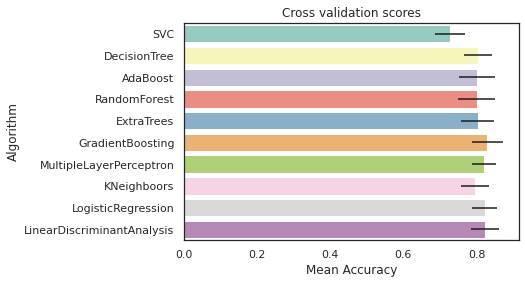

In [78]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})

# 그래프 설정
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

- 교차 검증을 이용하여 모델의 성능을 평가한 결과, SVC, AdaBoost, RandomForest , ExtraTrees, GradientBoosting 분류 모델을 사용하기로 결정하였다.

##### **6.1.2 Hyperparameter tunning for best models**
: 그리드서치를 이용하여 앞에서 사용하기로 한 5개의 모델의 하이퍼 파라미터 튜닝을 진행한다. `n_jobs`를 cpu에 따라 4로 설정하였으며, 이 덕분에 코드 실행 시간이 줄어들었다.

In [81]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,Y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=7),
             n_jobs=4,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,
                                           1.5],
                         'n_estimators': [1, 2]},
             scoring='accuracy', verbose=1)

In [82]:
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

0.8275536261491316

___

In [83]:
# ExtraTrees 
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train,Y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=ExtraTreesClassifier(), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None], 'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=1)

In [84]:
ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

0.8285878447395302

___

In [85]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train,Y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None], 'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=1)

In [86]:
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

0.8331460674157304

___

In [87]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['deviance'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [88]:
GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

0.8308861082737486

___

In [90]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(X_train,Y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(probability=True), n_jobs=4,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [91]:
SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

0.8331332992849847

- 각 모델 별로 하이퍼 파라미터 튜닝을 진행하였으며, 최적 하이퍼 파라미터 모델을 별도의 변수에 저장하고, 그 성능을 확인해보았다.

##### **6.1.3 Plot learning curves**
: 과적합 여부를 확인하기 위해, 학습 곡선을 그려보았다.

In [92]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    # Generate a simple plot of the test and training learning curve
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

- RandomForest 학습 곡선(지표 : 정확도)

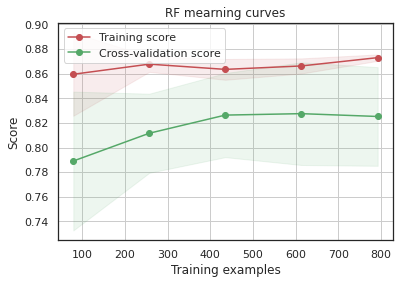

In [93]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)

- ExtraTrees 학습 곡선(지표 : 정확도)

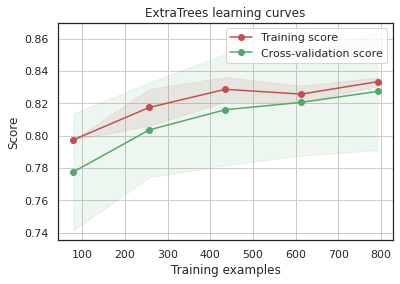

In [94]:
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)

- SVC 학습 곡선(지표 : 정확도)

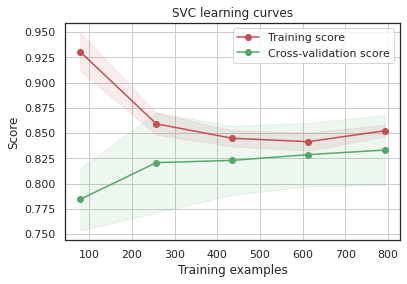

In [95]:
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)

- AdaBoost 학습 곡선(지표 : 정확도)

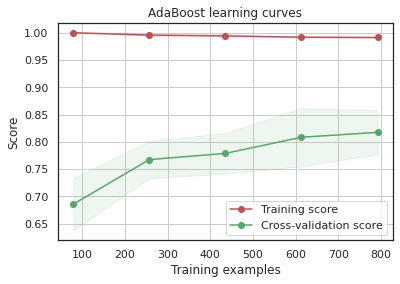

In [96]:
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)

- GradientBoosting 학습 곡선(지표 : 정확도)

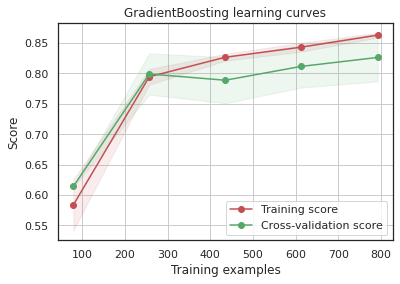

In [97]:
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- 학습 데이터셋의 학습 곡선이 계속 증가하는 것을 보아, GradientBoosting과 AdaBoost 모델이 학습 데이터셋에 과적합된 것으로 보인다.
- 반면 SVC와 ExtraTrees, RandomForest는 두 곡선이 서로 가까이 있는 것을 보아, 테스트셋에서의 성능 역시 좋을 것 같다.

##### **6.1.4 Feature importance of tree based classifiers**
: 생존 확률에 가장 많은 영향을 끼친 피처들을 확인하기 위해 피처 중요도를 시각화했다.

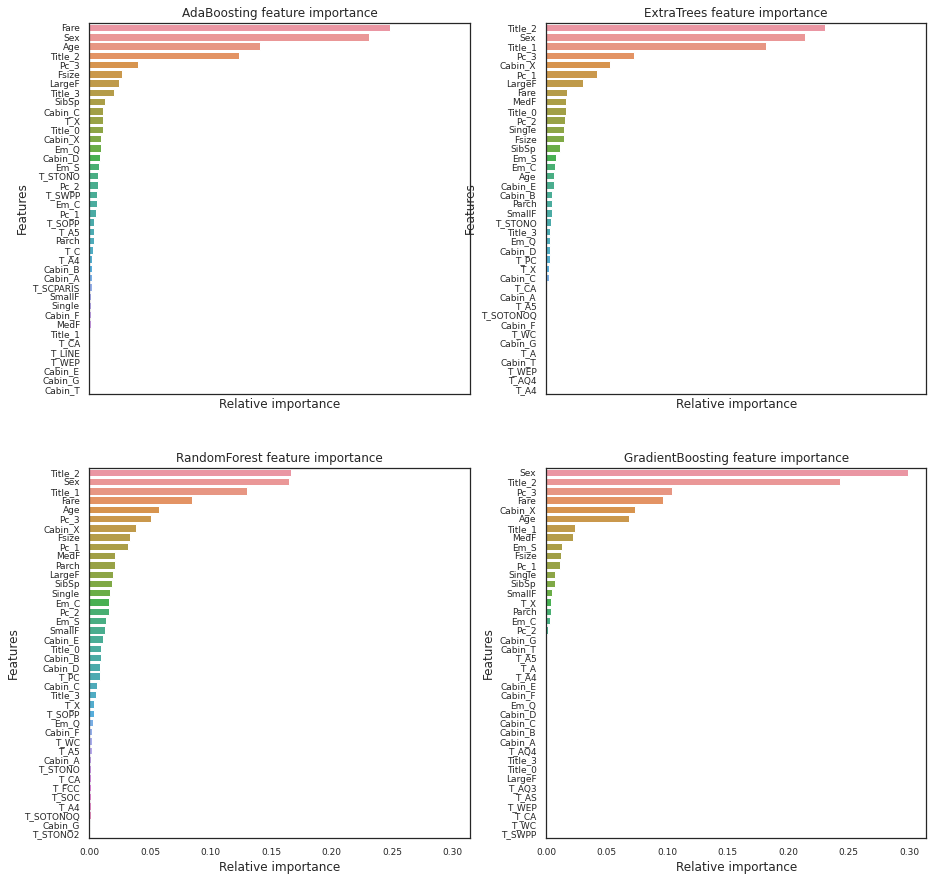

In [98]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

- Adaboost, ExtraTrees, RandomForest 그리고 GradientBoosting 4가지 분류 모델의 피처 중요도를 시각화했는데, 각 모델마다 중요도가 높은 피처들이 조금씩 다른 것을 확인할 수 있다.
- 이것은 동일한 피처를 기반으로 예측하지 않았다는 것을 보여준다.
- 그러나 `Fare`, `Title_2`, `Age` 그리고 `Sex`와 같이 공통적으로 중요한 피처에 속한 피처들이 존재한다.

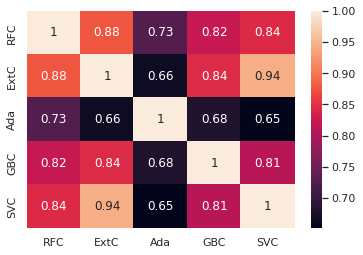

In [99]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

- 예측값은 Adaboost를 제외하고 4개의 분류 모델에서 비슷하게 계산되었다.
- 이 차이를 활용하여, 투표 기반 분류 모델을 만들어 보았다.

#### | **6.2 Ensemble modeling**
___
- 간접 투표 기반 모델을 생성하였다.

In [100]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

#### | **6.3 Prediction**
___


In [101]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)